# Validation

In [2]:
import sys

sys.path.append("../")

from __init__ import *
from data_tools import *

## Calculating Tau

The first thing to note is the Tau value of our data. Let us choose an event, take a 40.96 $\mu s$ time slice, calculate an FFT and also observe the associated truth data.

In [3]:
file = path + '90harmonic.h5'

strings, attributes, attributes_values = get_attributes(file)
print(strings[0], "has a", attributes[9], 'equal to', attributes_values[0][9], 'Ohms')

signal = get_signal(file, strings[0])
no_samples = 40960 # For a 40.96 us time slice

signal_fft = np.fft.rfft(signal, no_samples)

print('Time slice is', no_samples * 1e-9 * 1e6, ' micro seconds')
print('With a total number of ', len(np.abs(signal_fft)), 'Bins')

signal1 has a Waveguide impedance [Ohms] equal to 496.1709043911709 Ohms
Time slice is 40.96  micro seconds
With a total number of  20481 Bins


Tau is defined as 
$$ \tau = kTBR / N_{FFT} $$

In [4]:
R = attributes_values[0][9]
N_fft = len(np.abs(signal_fft))

tau = k * T * B * R / N_fft
print(tau)

8.357939652114349e-16


## Validating Rayleigh Distributions

Testing a single Rayleigh bin with manual and scipy implementation (with scaling)

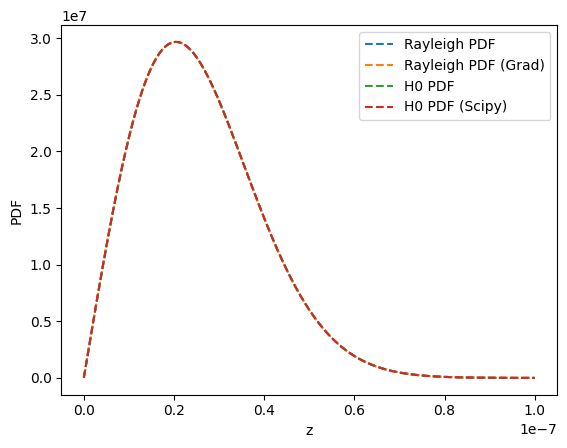

KS Test Results:
Comparison 1 vs 2: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 1 vs 3: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 1 vs 4: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 2 vs 3: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 2 vs 4: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 3 vs 4: KS Statistic = 0.00000000, p-value = 1.00000000


In [30]:
z_values = np.linspace(0, 1e-7, 1000)
N_bin = 1

# No Scipy 
null_dist = H0_PDF(z_values, tau, 1, scipy=False)

# Scipy
null_dist_scipy = H0_PDF(z_values, tau, 1, scipy=True) 

# Numerical Differentiation
cdf_dist = rayleigh_CDF(z_values, tau, N_bin=1)
pdf_dist = numerical_derivative_rayleigh_CDF(z_values, tau, N_bin, delta=1e-10)

# Numerical Differentiation pt.2
pdf_dist_grad = np.gradient(cdf_dist, z_values)

plt.plot(z_values, pdf_dist, label='Rayleigh PDF', linestyle='--')
plt.plot(z_values, pdf_dist_grad, label='Rayleigh PDF (Grad)', linestyle='--')

plt.plot(z_values, null_dist, label='H0 PDF', linestyle='--')
plt.plot(z_values, null_dist_scipy, label='H0 PDF (Scipy)', linestyle='--')
plt.legend()
plt.xlabel('z')
plt.ylabel('PDF')
plt.show();

# distributions = [pdf_dist, pdf_dist_grad, null_dist, null_dist_scipy]

# for dist in distributions:
#     print(scipy.integrate.trapezoid(dist, z_values))

# KS Test
distributions = [pdf_dist, pdf_dist_grad, null_dist, null_dist_scipy]

results = {}

print('KS Test Results:')

for i in range(len(distributions)):
    for j in range(i + 1, len(distributions)):
        stat, p_value = ks_2samp(distributions[i], distributions[j])
        results[f'Comparison {i+1} vs {j+1}'] = {'KS Statistic': stat, 'p-value': p_value}

# Display results
for comparison, result in results.items():
    print(f"{comparison}: KS Statistic = {result['KS Statistic']:.8f}, p-value = {result['p-value']:.8f}");

#

Testing a single Rician bin with manual and scipy implementation (with scaling)

Testing a single Rician bin and Rayleigh vs 2 Rayleigh.

Now a larger dummy test

Real data test for all the different pitch angles. 